In [1]:
import matplotlib.pyplot as plt

In [2]:
from shapely.geometry import Polygon

In [3]:
from nbhd import data, geography, geometry

In [4]:
db = data.Base()

Initializing database connection...
Database connected!


In [5]:
x_min, x_max, y_min, y_max = 336097, 339909, 390882, 393101

In [6]:
box = Polygon([(x_min, y_min),
               (x_min, y_max),
               (x_max, y_max),
               (x_max, y_min),
               (x_min, y_min)])

In [7]:
roads = db.intersects('roads', box.buffer(100))

<AxesSubplot:>

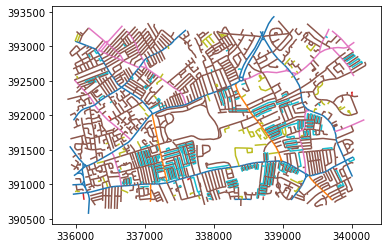

In [8]:
roads.plot('road_function')

In [9]:
trimmed = roads.geometry.apply(lambda x: geometry.trim(x, box.buffer(100)))

<AxesSubplot:>

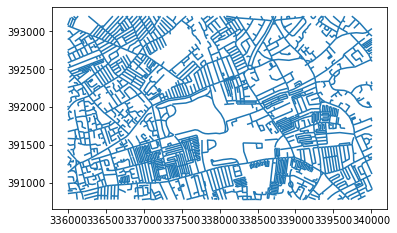

In [10]:
trimmed.plot()

In [11]:
settings = {'footprint_threshold':250,
            'res_length_threshold':30,
            'short_threshold':10,
            'min_community_size':20,
            'node_distance':5}

In [12]:
df, subgraphs = geography.get_communities(db, box, **settings)

Starting to find neighbourhoods in polygon centred at POINT (338003 391991.5)
Collected 37583 properties...
... of which 34364 are in buildings
Getting streets...
Snapping nodes...
Finding connected graphs...
Labelling communities.


In [13]:
import geopandas as gpd

In [14]:
roads = gpd.GeoDataFrame(df[['roads_id', 'community']],
                        geometry=gpd.GeoSeries.from_wkb(df.roads_geometry))

In [15]:
roads = roads.loc[~roads.roads_id.duplicated()]

In [16]:
roads['geometry'] = roads.geometry.apply(lambda x: geometry.trim(x, box))

In [17]:
buildings = gpd.GeoDataFrame(df[['buildings_id','community']],
                             geometry=gpd.GeoSeries.from_wkb(df.buildings_geometry))

In [18]:
buildings = buildings.loc[~buildings.buildings_id.duplicated()]

In [19]:
buildings.geometry = buildings.geometry.apply(lambda x: geometry.trim(x, box))

In [20]:
properties = gpd.GeoDataFrame(df[['properties_id', 'community']],
                             geometry=gpd.GeoSeries.from_wkb(df.properties_geometry))

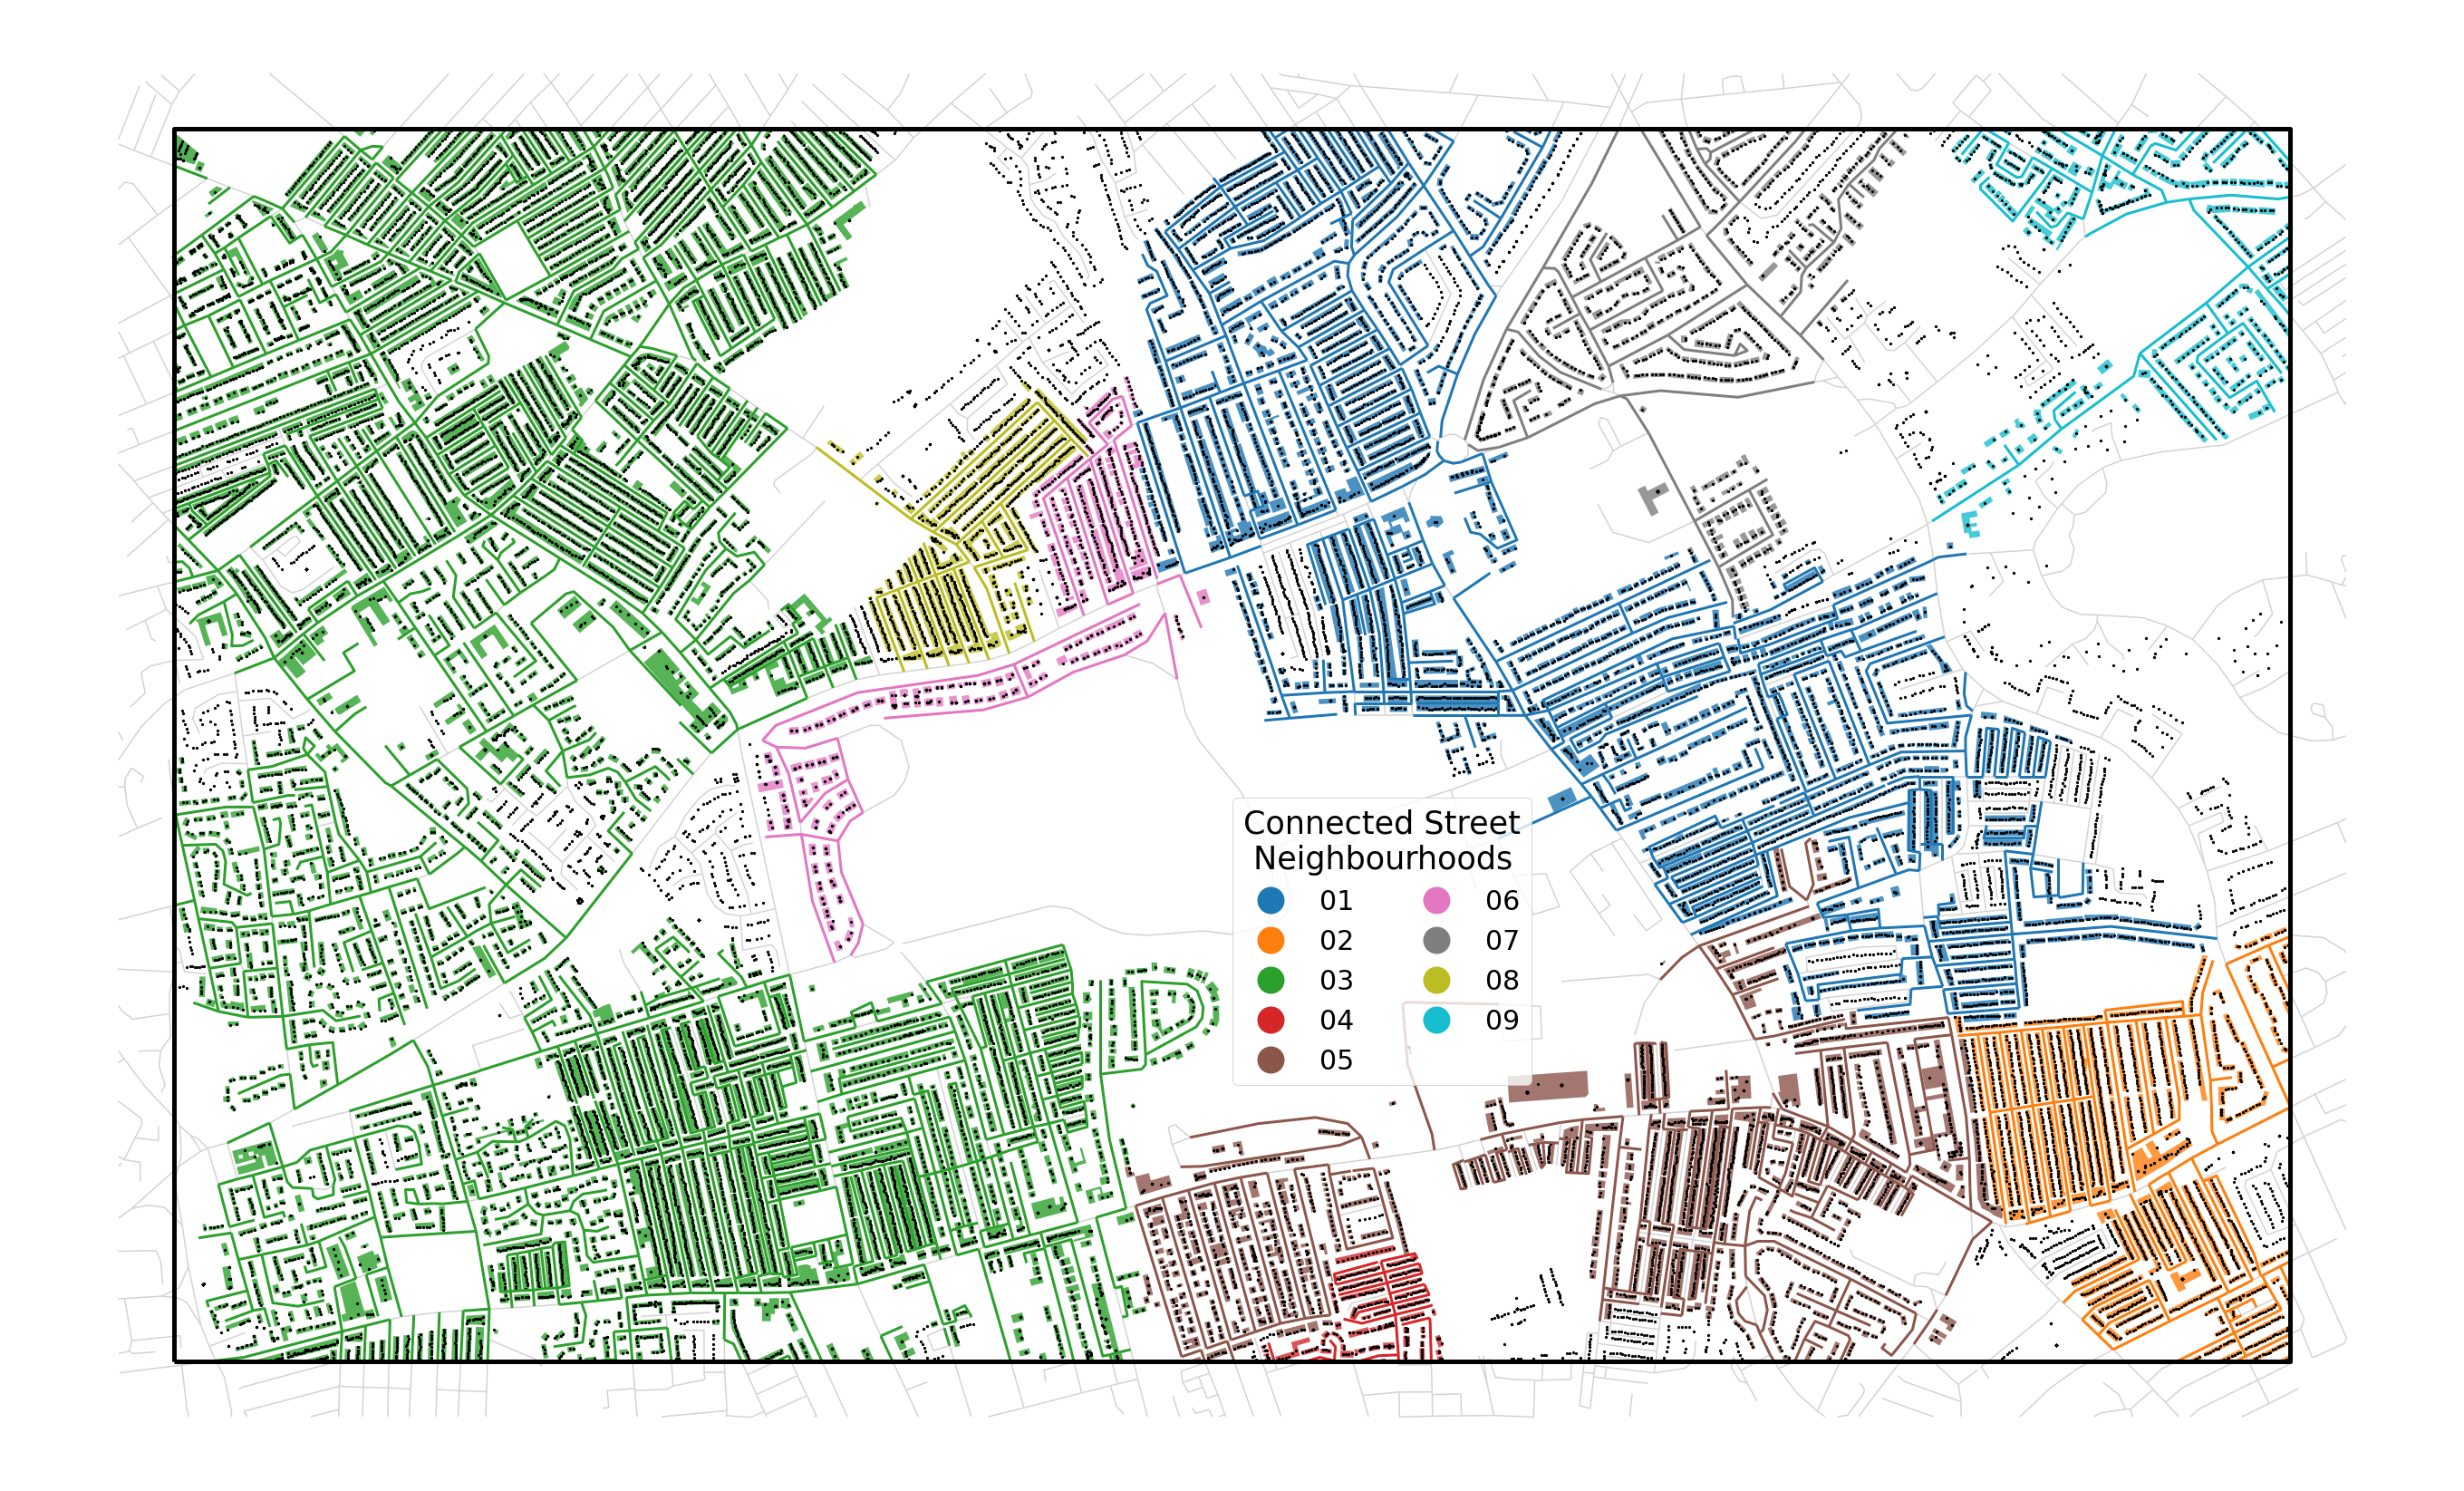

In [21]:
cmap='tab10'
fig, ax = plt.subplots(figsize=(60,30))
trimmed.plot(color='lightgrey', ax=ax)
buildings.plot('community', alpha=0.8, ax=ax, cmap=cmap)
roads.plot('community', ax=ax, linewidth=3, cmap=cmap, legend=True, 
           legend_kwds={'fontsize':30, 
                        'markerscale':3,
                        'loc':(0.5,0.27),#'best',
                        'title': 'Connected Street\n Neighbourhoods',
                        'title_fontsize':35,
                        'markerfirst': True,
                        'ncol':2})
properties.plot(color='k', ax=ax, markersize=5)
gpd.GeoSeries(box).boundary.plot(color='k', linewidth=5, ax=ax)
ax.set_axis_off()

In [22]:
ax.figure.savefig('../fig/connected_nbhd.png',
                  bbox_inches='tight',
                 transparent=False, pad_inches=0)